In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from math import pi
import folium
%matplotlib inline
import shapely
from shapely.geometry import *
import pysal as ps
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.transforms import blended_transform_factory
import math


In [2]:
blocks = gpd.read_file('Oakland_Blocks.shp').set_index('GEOID10')['geometry']


In [3]:
def compactness_measure(x):
    block_area = x.area
    block_perimeter = x.length
    block_radius = block_perimeter / (2*pi)
    circ_area = pi*block_radius**2
    return block_area/circ_area
cp1 = blocks.apply(compactness_measure)

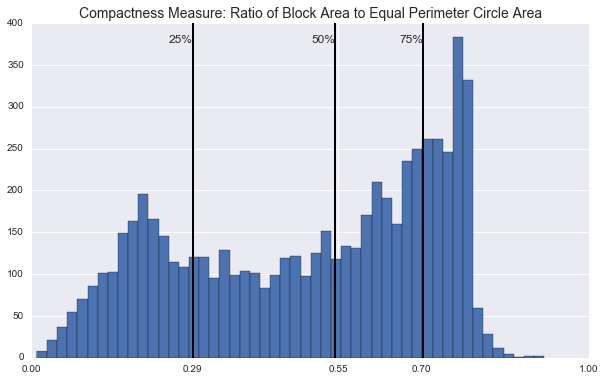

In [4]:
fig, ax = plt.subplots()
cp1.hist(bins=50, ax=ax)
t=ax.set_title('Compactness Measure: Ratio of Block Area to Equal Perimeter Circle Area', fontsize=14)
tform = blended_transform_factory(ax.transData, ax.transAxes)

qs = cp1.quantile([.25, .5, .75])
for i,q in qs.iteritems():
    label="{0:.0f}%".format(i * 100)
    ax.axvline(q, color='black', linewidth=2, linestyle='-')
    ax.annotate(label, xy=(q, 0), xycoords=tform, 
            xytext=(q, 0.95), textcoords=tform,
            ha='right', va='center', fontsize=12)
fig.set_size_inches(10,6)

a=ax.set_xticks(np.append([0,1,],qs.round(2)))



### Area to Perimeter Ratio 

With area / length measurement. Slivers have small areas relative to their length

More likely to be classified as a sliver if overall size is smaller (it is not a unitless measure)

area increases faster than length, so ratio gets larger for larger blocks and they are therefore less liekly to be classified as slivers if they are big areas (reasons why the stuff in the hills does not get classified as slivers)

said another way: threshold for not being a lsiver is higher in smaller blocks

Compactness: 0.785398163397
Area to Perimeter 0.25


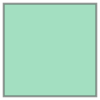

In [5]:
p1 = Polygon([[0,0],[0,1],[1,1],[1,0]])
print 'Compactness: {}'.format(compactness_measure(p1))
print 'Area to Perimeter {}'.format(p1.area/p1.length)
p1

Compactness: 0.785398163397
Area to Perimeter 1.0


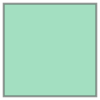

In [6]:
p2 = Polygon([[0,0],[0,4],[4,4],[4,0]])
print 'Compactness: {}'.format(compactness_measure(p2))
print 'Area to Perimeter {}'.format(p2.area/p2.length)
p2

Compactness: 0.326116884456
Area to Perimeter 0.882352941176


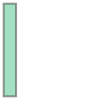

In [7]:
p3 = Polygon([[0,0],[0,15],[2,15],[2,0]])
print 'Compactness: {}'.format(compactness_measure(p3))
print 'Area to Perimeter {}'.format(p3.area/p3.length)
p3

Compactness: 0.999196680485
Area to Perimeter 0.998795456205


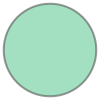

In [8]:
p4=Point(0,0).buffer(2)
print 'Compactness: {}'.format(compactness_measure(p4))
print 'Area to Perimeter {}'.format(p4.area/p4.length)
p4

In [19]:
cp1.corr(cp2)

0.39054672147596736

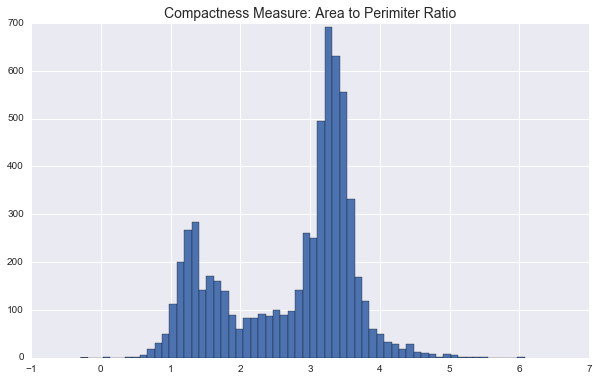

In [20]:
cp2 = np.log(blocks.area / blocks.length)
fig, ax = plt.subplots()
cp2.hist(bins=60, ax=ax)
t=ax.set_title('Compactness Measure: Area to Perimiter Ratio', fontsize=14)

fig.set_size_inches(10,6)



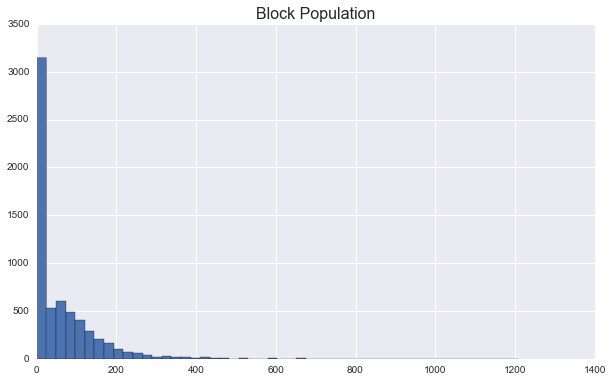

In [21]:
block_pop = pd.read_csv('Oakland_Block_Pop.csv', header=None, dtype={0:np.object}, names=['GEOID10','POP']).set_index("GEOID10")['POP']
fig, ax = plt.subplots()
block_pop.hist(bins=50, ax=ax)
fig.set_size_inches(10,6)

t=ax.set_title('Block Population',fontsize=16)

In [18]:
gdf = gpd.GeoDataFrame(geometry=blocks)
gdf['CP1']=cp1
gdf['CP2']=cp2
gdf['CP3']=blocks.area/blocks.length**2
gdf['CP4']=np.log(cp2)
gdf['POP']=block_pop
gdf.to_file('C:/Temp/a_b.shp')

In [13]:
sliver1=(cp1<.3).astype(int).map({0:'Not Sliver', 1:'Sliver'})
sliver2=(cp2<16).astype(int).map({0:'Not Sliver', 1:'Sliver'})
sliver15=(cp1<.4).astype(int).map({0:'Not Sliver', 1:'Sliver'})

no_people=(block_pop<=10).astype(int).map({0:'More than 10 Pop', 1:'Less than 10 Pop'})


In [14]:
s1 = pd.crosstab(sliver1, no_people)
s1.index.name=None
s1.columns.name=None
print 'Compactness - Sliver = <.3'
s1

Compactness - Sliver = <.3


,Less than 10 Pop,More than 10 Pop
Not Sliver,1453,3190
Sliver,1392,247


In [15]:
s15 = pd.crosstab(sliver15, no_people)
s15.index.name=None
s15.columns.name=None
print 'Compactness - Sliver = <.4'
s15

Compactness - Sliver = <.4


,Less than 10 Pop,More than 10 Pop
Not Sliver,1072,2980
Sliver,1773,457


In [16]:
s2 = pd.crosstab(sliver2, no_people)
s2.index.name=None
s2.columns.name=None
print 'Area / Perimeter - Sliver = <16'
s2

Area / Perimeter - Sliver = <16


,Less than 10 Pop,More than 10 Pop
Not Sliver,676,3253
Sliver,2169,184
